<a href="https://colab.research.google.com/github/Sakib97/Bengali_Handwritten_Digit_Classifier/blob/main/numtaDB_classifier_pretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import numpy as np 
import pandas as pd
from torch.autograd import Variable

In [ ]:
import os
print(os.listdir("/content/"))

['.config', 'drive', 'sample_data']


In [ ]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-63e21aca-2dfa-cee1-3d58-b64097862a2b)


In [ ]:
import time
e_since = time.time()

!unzip -qq '/content/drive/My Drive/dataset_numtadb/numtaDB.zip'

time_elapsed = time.time() - e_since
print('completed in {:.4f}m {:.9f}s'.format( time_elapsed // 60, time_elapsed % 60))

completed in 1.0000m 25.108472824s


In [ ]:
data_dir = '/content/training-c'
print(os.listdir(data_dir)[:5])
len(os.listdir(data_dir))
#10908+19702+24298

['c09661.png', 'c00695.png', 'c19215.png', 'c23853.png', 'c09733.png']


24298

In [ ]:
# Let's combine A D
# csv first

a_csv = pd.read_csv('/content/training-a.csv')
a_csv.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [ ]:
a_csv = a_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
a_csv.iloc[:10, 0:]

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
5,a00005.png,4
6,a00006.png,3
7,a00007.png,0
8,a00008.png,4
9,a00009.png,9


In [ ]:
c_csv = pd.read_csv('/content/training-c.csv')
print(c_csv.columns)

c_csv = c_csv.drop(columns=['original filename', 'scanid',
       'database name original', 'contributing team', 'database name'])
c_csv.iloc[:10, 0:]

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7
5,c00005.png,3
6,c00006.png,4
7,c00007.png,7
8,c00008.png,5
9,c00009.png,3


In [ ]:
d_csv = pd.read_csv('/content/training-d.csv')
print(d_csv.columns)

d_csv = d_csv.drop(columns=['original filename', 'scanid', 'num', 'database name original',
       'database name'])
d_csv.iloc[:10, 0:]

Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')


,digit,filename
0,1,d00000.png
1,1,d00001.png
2,5,d00002.png
3,7,d00003.png
4,0,d00004.png
5,1,d00005.png
6,0,d00006.png
7,0,d00007.png
8,3,d00008.png
9,7,d00009.png


In [ ]:
#combine csv
frames = [a_csv,c_csv, d_csv]
label_csv = pd.concat(frames)

In [ ]:
len(label_csv)

54908

In [ ]:
# Now combine Image
path = '/content/train'
os.mkdir(path)

In [ ]:
import os
import shutil
src = '/content/training-a/'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, path)

print("A Done")

A Done


In [ ]:
src = '/content/training-c/'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, path)

print("C Done")

C Done


In [ ]:
src = '/content/training-d/'
src_files = os.listdir(src)
for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, path)

print("D Done")

D Done


In [ ]:
# path = '/content/train'
print(len(os.listdir(path)))


54908


t:  filename    a00100.png
digit                4
Name: 100, dtype: object
Label:  a00100.png
RGB


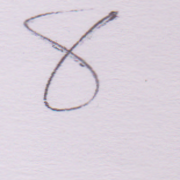

In [ ]:
from PIL import Image
t = label_csv.iloc[100]
print('t: ',t)
print("Label: ", t[0])
# name = os.listdir(data_dir)[10]
xx = Image.open(path+"/"+ str(t[0]))
print(xx.mode)
xx

In [ ]:
rgb = 0
other = 0
ot = []
for i in range (len(label_csv)):
  t = label_csv.iloc[i]
  im = Image.open(path+"/"+ str(t[0])).convert('RGB')
  if ((im.mode) == 'RGB'):
    rgb = rgb+1
  else:
    other = other+1
    ot.append(i)

print(rgb, '\n', other)
print(ot)

54908 
 0
[]


In [ ]:
# checking if rgb (JUNK)

# from scipy.misc import imread, imsave, imresize
from skimage import io, transform

im = io.imread(path+"/"+ str(t[0]))
# im = Image.open(path+"/"+ str(t[0]))

print(len(im.shape))

if(len(im.shape)<3):
      print ('gray')
elif len(im.shape)==3:
      print ('Color(RGB)')
else:
      print ('others')

3
Color(RGB)


Data loader
=======

In [ ]:
import torch
from torch.utils.data import Dataset
from skimage import io, transform

class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + str(item[0])
        # image = Image.open(path)
        image = Image.open(path).convert('RGB') # for pre-trained model
        # image = io.imread(path) # for pre-trained model
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
# prepare data
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(180),
    transforms.RandomRotation(30),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(180),
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
])

train_data  = Dataset(label_csv, path, train_transform)
test_data = Dataset(label_csv, path, test_transform)

print("Trainig Samples: ",len(train_data))

Trainig Samples:  54908


Prepare Loader
========

In [ ]:
# Prepare loader
# Batch Size: 128
# Split percentage: 20%

from torch.utils.data.sampler import SubsetRandomSampler

#batch size
batch_size=32

# split data 20% for testing
test_size = 0.2
# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
# defines the strategy to draw samples from the dataset.
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(len(train_sampler))
print(len(test_sampler))

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader))) # number of the batches
print("Test dataloader:{}".format(len(test_loader)))   # number of the batches

43927
10981
Train dataloader:1373
Test dataloader:344


In [ ]:
classes = list()
for i in range(10):
    classes.append(str(i))
classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
!wget https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
import Helper

--2020-07-05 06:52:48--  https://raw.githubusercontent.com/Iamsdt/DLProjects/master/utils/Helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21413 (21K) [text/plain]
Saving to: ‘Helper.py’

Helper.py           100%[===================>]  20.91K  --.-KB/s    in 0.007s  

2020-07-05 06:52:48 (2.80 MB/s) - ‘Helper.py’ saved [21413/21413]



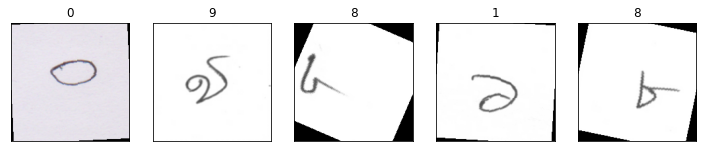

In [ ]:
# visualize the data

# import Helper
# from torch.utils.tensorboard import SummaryWriter

data_iter = iter(train_loader)
images, labels = data_iter.next()
# for batch in train_loader:
#     images, labels = batch
#     break

fig = plt.figure(figsize=(25, 10))
for idx in range(5):
        ax = fig.add_subplot(1, 10, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.transpose(images[idx].numpy(), (1, 2, 0)))
        ax.set_title(classes[labels[idx]])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 10)

model = model.to(device)

In [ ]:
# INSTANTIATE OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [ ]:
# Training Loop
import torch.nn.functional as F
import time
iteration_loss = []
since = time.time()

for epoch in range(3):
  # total_loss = 0
  # total_correct = 0
  e_since = time.time()

  running_loss = 0.0
  running_corrects = 0
  total = 0

  for batch in train_loader:
    model.train()
    images, labels = batch

    # images = images.view(-1, 224*224).to(device)
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    # Forward pass to get output/logits
    # logits, probas = model(images)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    loss = criterion(outputs, labels) 

    # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
    # loss = F.cross_entropy(logits, labels)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    total += labels.size(0)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data)
  
  epoch_loss = running_loss / len(train_loader)
  # epoch_acc = running_corrects / len(train_loader)
  epoch_acc = (running_corrects.double() / total) * 100

  print('epoch: {}. Total: {}. Correct: {}. Train Loss: {:.4f}. Train Acc: {:.4f}.'.format(epoch, total, running_corrects, epoch_loss, epoch_acc))
  valid_correct = 0
  total = 0
  valid_loss = 0
  for images, labels in test_loader:
      model.eval()
  
      # images = images.view(-1, 224*224).to(device)
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      loss_p = criterion(outputs, labels)

      # Total number of labels
      total += labels.size(0)

      valid_loss += loss_p.item() * images.size(0)
      valid_correct += torch.sum(predicted == labels.data)

  valid_epoch_loss = valid_loss / len(test_loader)
  # epoch_acc = running_corrects / len(train_loader)
  valid_epoch_acc = (valid_correct.double() / total) * 100

  print('epoch: {}. Total: {}. Correct: {}. Valid Loss: {:.4f}. Valid Acc: {:.4f}.'.format(epoch, total, valid_correct, valid_epoch_loss, valid_epoch_acc))
  

  time_elapsed = time.time() - e_since
  # accuracy = 100 * correct.item() / total

  # print("epoct:", epoch, "total_correct:", total_correct, "loss:", total_loss)
  # iteration_loss.append(loss.item())
  # print('epoch: {}. data: {}. Loss: {}. Accuracy: {}'.format( epoch, total, loss.item(), accuracy))
  print('\nEpoch:{} completed in {:.0f}m {:.0f}s'.format(epoch, time_elapsed // 60, time_elapsed % 60))

# compare total time
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

epoch: 0. Total: 43927. Correct: 36560. Train Loss: 23.3524. Train Acc: 83.2290.
epoch: 0. Total: 10981. Correct: 10813. Valid Loss: 2.6422. Valid Acc: 98.4701.

Epoch:0 completed in 4m 53s
epoch: 1. Total: 43927. Correct: 42772. Train Loss: 3.5205. Train Acc: 97.3706.
epoch: 1. Total: 10981. Correct: 10883. Valid Loss: 1.2509. Valid Acc: 99.1075.

Epoch:1 completed in 4m 51s
epoch: 2. Total: 43927. Correct: 43148. Train Loss: 2.2286. Train Acc: 98.2266.
epoch: 2. Total: 10981. Correct: 10908. Valid Loss: 0.8894. Valid Acc: 99.3352.

Epoch:2 completed in 4m 51s
Training completed in 14m 36s
